This notebook is used to visualize the latent space of the primary gait transformer.

In [2]:
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import WindowedGaitDataset, ToTensor, ExobootDataset
from gait_transformer import PositionalEncoder
from save_best_model import SaveBestModel
from training_utils import phase_dist, unscale_kinematics, unscale_gait_state
from torch_training_utils import GaitLoss, EWC, enum_parameters

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

Import the datafiles containing the walking data used to train the network

In [3]:
window_size = 150 #set the number of kinematics in the buffer to the transformer

#set up kinematics scaling
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

#set up gait state scaling
speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)

#set up filenames for each data file
filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=10000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=10000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=10000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=10000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=10000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=10000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)




#concatenate
gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                        gait_data_dataport_ordered, gait_data_dataport_randomized,\
                        gait_data_gt_ordered, gait_data_gt_randomized])

# gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized])


vicon_dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())

print('{:>5,} samples'.format(len(vicon_dataset)))

#SET BATCH SIZE
BATCH_SIZE = 4096//4
# BATCH_SIZE = 32
NUM_WORKERS = 1

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
vicon_dataloader = DataLoader(
            vicon_dataset,  # The training samples.
            shuffle=True,
            batch_size = BATCH_SIZE, # Trains with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )


16,437,120 samples


In [4]:
class GaitTransformerWithLatentSpace(nn.Module):
    """This class encodes the primary Transformer that translates a measurement buffer of kinematics
    to a succinct gait state at the present time
    """    
    def __init__(self, 
        input_size: int,
        num_predicted_features: int=4,
        batch_first: bool=True,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        enc_seq_len: int=50,
        dropout_encoder: float=0, 
        dropout_decoder: float=0,
        dropout_pos_enc: float=0,
        dropout_regression: float = 0,
        dim_feedforward_encoder: int=128,
        dim_feedforward_decoder: int=128,
        ): 
        """_summary_

        Args:
            input_size (int): number of input variables/kinematics.
            num_predicted_features (int, optional): The number of gait states to predict. Defaults to 4.
            batch_first (bool, optional): whether to process/train the network using batch first inputs. Defaults to True.
            dim_val (int, optional): The dimension of the Transformer latent space. Defaults to 512.
            n_encoder_layers (int, optional): number of encoder layers. Defaults to 4.
            n_decoder_layers (int, optional): number of decoder layers. Defaults to 4.
            n_heads (int, optional): The number of parallel attention heads. Defaults to 8.
            enc_seq_len (int, optional): The maximum encoder sequence length. Defaults to 50.
            dropout_encoder (float, optional): the dropout rate of the encoder. Defaults to 0.
            dropout_decoder (float, optional): the dropout rate of the decoder Defaults to 0.
            dropout_pos_enc (float, optional): the dropout rate of the positional encoder. Defaults to 0.
            dropout_regression (float, optional): the dropout rate of the regression head. Defaults to 0.
            dim_feedforward_encoder (int, optional): number of neurons in the linear layer of the encoder. Defaults to 128.
            dim_feedforward_decoder (int, optional): number of neurons in the linear layer of the decoder. Defaults to 128.
        """    
    
        super().__init__() 


        # The input linear layer needed for the encoder
        self.embedding_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )


        # The encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            activation='gelu',
            batch_first=batch_first
            )
        
        # The input linear layer needed for the decoder
        self.decoder_embedding_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )
        
        #the decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            activation='gelu',
            batch_first=batch_first
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc,
            max_seq_len=enc_seq_len
            )
        
        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )
        
        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

        # Create the regression head
        self.regression_head = nn.Sequential(
            nn.LayerNorm(dim_val),
            nn.Dropout(dropout_regression),
            nn.Linear(dim_val,  num_predicted_features)
        )


    def forward(self, src: Tensor, tgt: Tensor, dts : Tensor) -> Tensor:
        """
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
           
           tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            
            dts: the vector of time steps used to encode the positions of the input
            
        """

        # Pass throguh the input layer right before the encoder
        src = self.embedding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features

        #encoder the positions
        src = self.positional_encoding_layer(src, dts) # src shape: [batch_size, src length, dim_val] regardless of number of input features

        ## ENCODER
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
       
       ## DECODER
        decoder_output = self.decoder_embedding_layer(tgt) # tgt shape: [batch_size, target sequence length, dim_val] regardless of number of input features
        
        # Pass through decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src
            )
        
        # Pass through regression head
        output = self.regression_head(decoder_output)
        
        # force the outputs of is_stairs to be in [0,1] via sigmoid
        output[:,:,4] = torch.sigmoid(output[:,:,4])

        return output, src


In [5]:
# Model parameters
dim_val = 32 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 150 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1
dim_feedforward_encoder = 512
dim_feedforward_decoder = 512

num_predicted_features = 5 # The number of output variables. 

best_model = GaitTransformerWithLatentSpace(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


best_model.to(device)

model_nickname = 'apollyon-three-stairs'
model_dir = f'../full_models/{model_nickname}/model_save_xval/'
    

checkpoint = torch.load(model_dir+'ml_gait_estimator_dec_best_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)


epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

#Extract index for time steps
DT_IDX = 6


Using GPU.
Lowest Loss: 0.11826772387912407


In [18]:
z_latent_total = np.array([])
b_state_vicon_total = np.array([])

for i in range(10):
    # Get latent space representation for some input data x
    batch_vicon = next(iter(vicon_dataloader))
    b_kinematics_vicon = batch_vicon['meas'].to(device) # shape (batch_size, seq_len, num_kinematics)
    b_state_vicon = batch_vicon['state'].to(device) # shape (batch_size, seq_len, num_gait_states)

    b_state_vicon = b_state_vicon[:,-1,:]

    tgt = SOS_token.repeat(b_state_vicon.shape[0], 1, 1)
    dts = b_kinematics_vicon[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)



    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = best_model(b_kinematics_vicon,tgt, dts)


    _, z_latent = best_model(b_kinematics_vicon, tgt, dts)
    b_state_vicon = unscale_gait_state(b_state_vicon.detach().cpu().numpy(), speed_scale, incline_scale, stair_height_scale)

    # print('z_latent')
    # print(z_latent.shape)
    z_latent = z_latent.detach().cpu().numpy() # shape (batch_size, seq_len, latent_dim)


    #extract only the last element
    # z_latent = z_latent[:,-1,:]
    z_latent = z_latent.reshape(b_state_vicon.shape[0],-1)
    
    if i == 0:
        z_latent_total = z_latent
        b_state_vicon_total = b_state_vicon
        
    else:
        z_latent_total = np.vstack((z_latent_total, z_latent))
        b_state_vicon_total = np.vstack((b_state_vicon_total, b_state_vicon))


In [ ]:
z_latent = z_latent_total
b_state_vicon = b_state_vicon_total
# set up grouping masks
is_stairs_ascent_mask = b_state_vicon[:,3] > 0.5
is_stairs_descent_mask = b_state_vicon[:,3] < -0.5

is_ramp_ascent_mask = b_state_vicon[:,2] > 0
is_ramp_descent_mask = b_state_vicon[:,2] < 0

regular_walking_mask = ~is_stairs_ascent_mask & ~is_stairs_descent_mask & ~is_ramp_ascent_mask & ~is_ramp_descent_mask


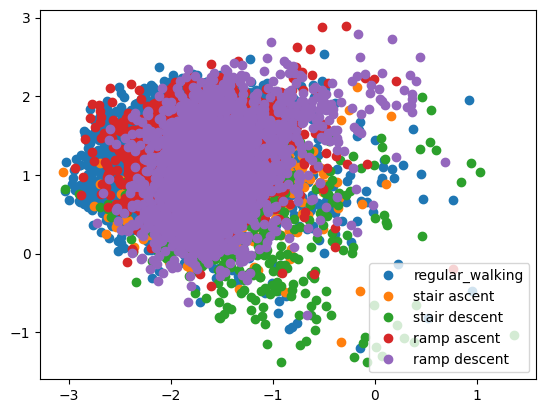

In [19]:
# plot the first few dimensions of the vicon latent space to analyze clustering in the gait states

# Reshape z to be a single 3D tensor

DIM_0 = 18
DIM_1 = 2

fig, ax = plt.subplots()
ax.plot(z_latent[regular_walking_mask,DIM_0], z_latent[regular_walking_mask,DIM_1], 'o',label='regular_walking')
ax.plot(z_latent[is_stairs_ascent_mask,DIM_0], z_latent[is_stairs_ascent_mask,DIM_1], 'o',label='stair ascent')
ax.plot(z_latent[is_stairs_descent_mask,DIM_0], z_latent[is_stairs_descent_mask,DIM_1], 'o',label='stair descent')
ax.plot(z_latent[is_ramp_ascent_mask,DIM_0], z_latent[is_ramp_ascent_mask,DIM_1], 'o',label='ramp ascent')
ax.plot(z_latent[is_ramp_descent_mask,DIM_0], z_latent[is_ramp_descent_mask,DIM_1], 'o',label='ramp descent')
# ax.plot(z_latent[:,DIM_0], z_latent[:,DIM_1], 'k.',label='ramp descent')
ax.legend()
plt.show()

In [38]:
from sklearn.manifold import TSNE


# Apply t-SNE to reduce dimensionality to 2D
z_latent_tsne = z_latent
# z_latent_tsne = z_latent_exo
z_2d_tsne = TSNE(n_components=2,random_state=42).fit_transform(z_latent_tsne)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


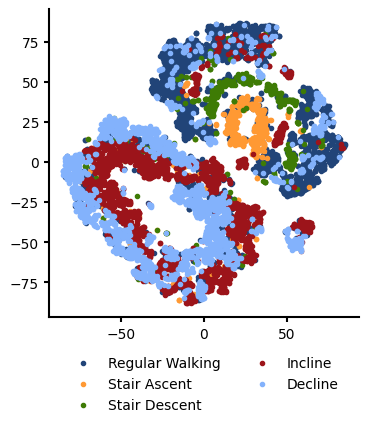

In [51]:
figWidth = 4
figHeight = 4

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12


greenColor = '#3e7b05ff'
blueColor = '#214478'
redColor = '#9c141a'
purpleColor = '#332288ff'
grayColor = '#72746fff'
orangeColor = '#ff9933'
lightBlueColor = '#83b2fc'
alpha=1.0
markersize=3


fig, ax = plt.subplots(figsize=(figWidth,figHeight))
ax.plot(z_2d_tsne[regular_walking_mask,0], z_2d_tsne[regular_walking_mask,1], 'o',color=blueColor,label='Regular Walking', alpha=alpha, markersize=markersize)
ax.plot(z_2d_tsne[is_stairs_ascent_mask,0], z_2d_tsne[is_stairs_ascent_mask,1], 'o',color=orangeColor,label='Stair Ascent', alpha=alpha, markersize=markersize)
ax.plot(z_2d_tsne[is_stairs_descent_mask,0], z_2d_tsne[is_stairs_descent_mask,1], 'o',color=greenColor,label='Stair Descent', alpha=alpha, markersize=markersize)
ax.plot(z_2d_tsne[is_ramp_ascent_mask,0], z_2d_tsne[is_ramp_ascent_mask,1], 'o',color=redColor,label='Incline', alpha=alpha, markersize=markersize)
ax.plot(z_2d_tsne[is_ramp_descent_mask,0], z_2d_tsne[is_ramp_descent_mask,1], 'o',color=lightBlueColor,label='Decline', alpha=alpha, markersize=markersize)
ax.legend(frameon=False,fontsize=MEDIUM_SIZE, loc='lower center',bbox_to_anchor=(0.5,-0.35),ncol=2)



# make figure fancy for paper
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["mathtext.default"] = "regular"


ax.xaxis.set_tick_params(labelsize=MEDIUM_SIZE)
ax.yaxis.set_tick_params(labelsize=MEDIUM_SIZE)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)


# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

filename = f'../paper_plotting/latent_space_raw.png'
plt.savefig(filename, transparent=True,pad_inches=0,bbox_inches='tight', dpi=300)

filename = f'../paper_plotting/latent_space_raw.svg'
plt.savefig(filename, transparent=True,pad_inches=0,bbox_inches='tight')

plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


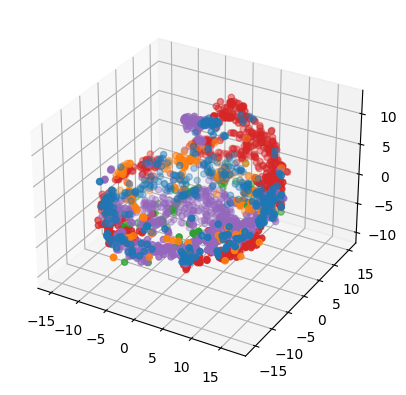

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality to 3D
z_3d = z_latent

z_3d_tsne = TSNE(n_components=3).fit_transform(z_3d)

# Visualize the latent space with a 3D heatmap
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(z_3d_tsne[regular_walking_mask,0], z_3d_tsne[regular_walking_mask,1], z_3d_tsne[regular_walking_mask,2],  'o',label='regular_walking')
ax.scatter(z_3d_tsne[is_stairs_ascent_mask,0], z_3d_tsne[is_stairs_ascent_mask,1], z_3d_tsne[is_stairs_ascent_mask,2], 'o',label='stair ascent')
ax.scatter(z_3d_tsne[is_stairs_descent_mask,0], z_3d_tsne[is_stairs_descent_mask,1], z_3d_tsne[is_stairs_descent_mask,2], 'o',label='stair descent')
ax.scatter(z_3d_tsne[is_ramp_ascent_mask,0], z_3d_tsne[is_ramp_ascent_mask,1], z_3d_tsne[is_ramp_ascent_mask,2], 'o',label='ramp ascent')
ax.scatter(z_3d_tsne[is_ramp_descent_mask,0], z_3d_tsne[is_ramp_descent_mask,1], z_3d_tsne[is_ramp_descent_mask,2], 'o',label='ramp descent')


# ax.scatter(z_3d_tsne[:,0], z_3d_tsne[:,1], z_3d_tsne[:,2], cmap='coolwarm')
plt.show()